<a href="https://colab.research.google.com/github/lars-x/Umu_Labs/blob/main/Lab1/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Attacks on Traffic Sign Classification

Lars Johansson

## Summary

I assume the reader is familiar with the document:

https://adversarial-ml-tutorial.org/adversarial_examples/

I have tried to avoid copying text from that document. But a lot of code instead...

I have used Colab.

And without a GPU at the end, because of Google's secret rules:

https://research.google.com/colaboratory/faq.html#usage-limits

I transformed the traffic signs to grayscale.

### Assignment 1

I downloaded Kalle's dataset. It is already splitted in 3 parts:
````
File:     Number of examples:
train.p       34799
valid.p        4410
test.p        12630
Total         51839
````
It seems like the hyperparameters are well tuned. I have therefore not changed them, i.e.:
````
max_epochs = 10
lr=0.1
````
It looks like the model starts to overfit if max_epochs > 10.

Three different executions gave the following results:
````
Train accuracy = 99.99% Validation accuracy = 91.63% Test accuracy = 90.36%
Train accuracy = 99.92% Validation accuracy = 90.29% Test accuracy = 90.02%
Train accuracy = 99.91% Validation accuracy = 91.45% Test accuracy = 90.82%
````
Very little variance.

### Assignment 2

I have lowered some parameters to 1/10 so that I do not "see the attack so clear".

Typically, from 0.1 to 0.01, i.e:
````
delta = fgsm(model_cnn, X, y, 0.01)
````
and
````
delta = pgd_linf(model_cnn, X, y, epsilon=0.01, alpha=1e-2, num_iter=40)
````
2.1 Untargeted attack using Fast Gradient Sign Method (FGSM)
````
Epoch error : 0.3296296296296296
````
2.2 Untargeted attack using Projected Gradient Descent
````
Epoch error : 0.3592592592592593
````
2.3 Targeted attack using Projected Gradient Descent ver 1

I choose Speed limit (50km/h), Class Id = 2 as the target. I tuned epsilon to 0.03.
````
Accuracy = 28.25%
````
2.4 Targeted attack using Projected Gradient Descent ver 2
````
Accuracy = 59.11%
````

## Some of all my problems

Colab. I have really tried to like coding in Jupyter Notebook. But I do not think I will ever like it, probably due to too many years using Matlab. There are many not trivial problems to solve when using Colab: downloading files, disconnections, copy & paste, debugging and...

No GPU

I need flow when I am coding. Waiting 10 minutes to see if a code change is good is not good for flow. The training takes approximately 10 times longer on a Colab CPU compared to a GPU.

Image colors

Image shape

I have written a lot of code like:
````
axs[r, c].imshow(X[index].squeeze())

if image.shape[2] == 1: # Works localy, but not in Colab
````
Dataset and DataLoader was not trivial to understand:
````
stop_sign_loader = DataLoader(stop_sign_dataset, batch_size=stop_sign_dataset.__len__(), shuffle=False)
````
is an example of that I still do not understand it.

Grayscale in `transforms.Compose`

The class definition approach and the Sequential technique are somewhat confusing for a PyTorch beginner. I started with the class definition approach but ended with Sequential.
````
Flatten()
````
````
nn.Linear(7*7*64, 100)
````

````
CrossEntropyLoss()
````

Dimensions & conversions, i.e.: 
````
str(yp[i].max(dim=0)[1].numpy())
````
Dimensions and tuning in matplotlib, espesially for `plt.imshow`.

To understand Error messages:
````
TypeError: img should be PIL Image. Got <class 'numpy.ndarray'>

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x4096 and 3136x100)
````


## What I have learnt

"Coding" with a lot of help from Stackoverflow. A lot...

A lot of Python: file handling, pickle, matplotlib...

When I started, I understood very little of the demo code. Now I understand some more. My next steps will be to explore the code, by making changes and reading the documentation, and eventually I will completely understand the code.

Defining a PyTorch neural network for multi-class classification is not trivial.

The details of training a neural network with PyTorch are complicated but the code is relatively simple.

A little about images in Python and PyTorch, i.e., PIL.

And a little about Adversarial Attacks...

Let's start!


# 1. Train a CNN classifier with PyTorch for traffic sign recognition

## 1.1 Download zip datafile and load pickled data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import urllib.request
import zipfile
import pickle

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [2]:
data_dir = './data/'
training_file = data_dir + 'train.p'
validation_file = data_dir + 'valid.p'
testing_file = data_dir + 'test.p'
zip_file = data_dir + 'traffic-signs-data.zip'

if not (os.path.exists(training_file) and 
        os.path.exists(validation_file) and 
        os.path.exists(testing_file)):
    if not os.path.isdir(data_dir):
        os.makedirs(data_dir)

    print('Beginning data file downloading')
    url = 'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip'
    urllib.request.urlretrieve(url, zip_file)

    print('Beginning file unzip')
    zip_ref = zipfile.ZipFile(zip_file, 'r')
    zip_ref.extractall(data_dir)
    zip_ref.close()
    os.listdir(data_dir)
    print('Done')
else:
    print('No data file downloading needed')

Beginning data file downloading
Beginning file unzip
Done


In [3]:
print('Load pickled data')
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test = test['features'], test['labels']

Load pickled data


## 1.2 Dataset Summary & Exploration

In [4]:
print("Number of training examples   =", X_train.shape[0])
print("Number of validation examples =", X_valid.shape[0])
print("Number of testing examples    =", X_test.shape[0])
print("Total examples                =", X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])
# What's the shape of an traffic sign image?
print("Image data shape  =", X_train.shape[1:])
number_of_different_traffics_signs = len(np.unique(y_train))
print("Number of classes =", number_of_different_traffics_signs)

Number of training examples   = 34799
Number of validation examples = 4410
Number of testing examples    = 12630
Total examples                = 51839
Image data shape  = (32, 32, 3)
Number of classes = 43


In [5]:
# Visualize Image functions

def show_image(image, title):
    if len(image.shape) <= 3:
        plt.imshow(image, cmap="gray")
    elif image.shape[2] == 1: # Works localy, but not in Colab
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)

    plt.axis('off')
    plt.title(title)
    plt.show()

def show_images(X, y, indexes, cols):
    n = len(indexes)
    rows = int(np.ceil(n / cols))
    fig = plt.figure()
    i = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, i+1)
            plt.axis("off")
            if i >= n:
                continue
            index = indexes[i]
            plt.imshow(X[index].squeeze())
            plt.title(f'Class = {y[index]}')
            i = i + 1

    # fig.tight_layout()
    fig.set_figheight(rows*2)
    fig.set_figwidth(12)
    plt.show()


def get_n_random_indices_for_class(ys, n_random_indices, classe):
    indexes = []
    for index, y in enumerate(ys):
        if y == classe:
            indexes.append(index)

    indexes_total = len(indexes)
    indexes_random = np.random.choice(indexes, n_random_indices, replace=False)
    return indexes_random, indexes_total


def plot_image_distribution(x, y, xlabel, ylabel, width, color):
    plt.figure(figsize=(15, 7))
    plt.ylabel(ylabel, fontsize=18)
    plt.xlabel(xlabel, fontsize=16)
    plt.bar(x, y, width, color=color)
    plt.show()

Show some traffic signs


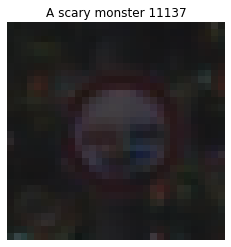

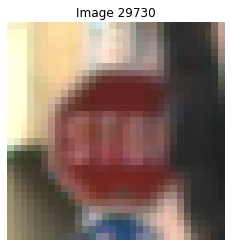

Stop Class Id = 14


In [6]:
print('Show some traffic signs')
i = 11137
show_image(X_train[i], f'A scary monster {i}')
i = 29730
show_image(X_train[i], f'Image {i}')
print(f'Stop Class Id = {y_train[i]}')

Show some Stop signs


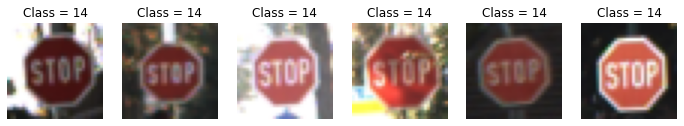

In [7]:
print('Show some Stop signs')
indexes = [29895, 29375, 29459, 29624, 29506, 29343]
show_images(X_train, y_train, indexes, cols = 6)

Show some random Stop signs


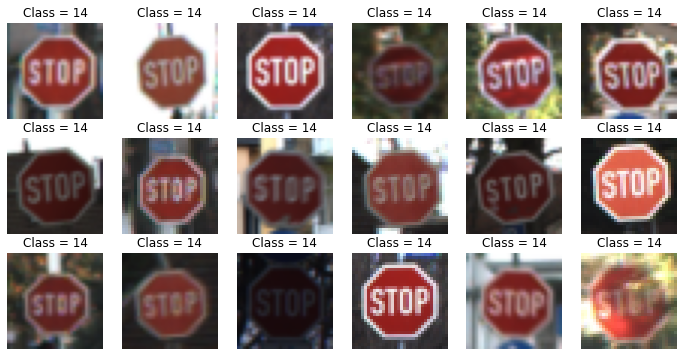

In [8]:
print('Show some random Stop signs')
stop_sign_class_id = 14
indexes_random, indexes_total = get_n_random_indices_for_class(y_train, 18, stop_sign_class_id)
show_images(X_train, y_train, indexes_random, cols = 6)

Show traffic signs distibution


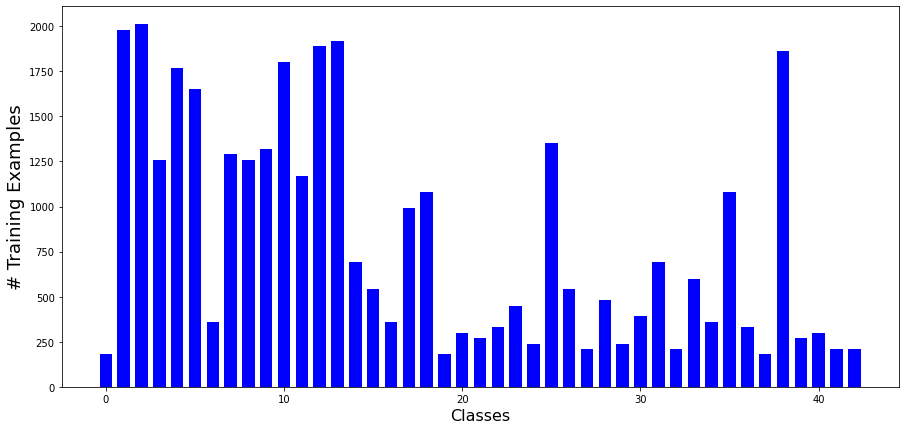

In [9]:
print('Show traffic signs distibution')
classes, counts = np.unique(y_train, return_counts=True)
plot_image_distribution(classes, counts, 'Classes', '# Training Examples', 0.7, 'blue')

## 1.3 Create Image Pytorch Datasets & DataLoaders

In [10]:
class ImageDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

transform = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.Grayscale(), 
    transforms.ToTensor()])

train_dataset = ImageDataset(X_train, y_train, transform=transform)
valid_dataset = ImageDataset(X_valid, y_valid, transform=transform)
test_dataset = ImageDataset(X_test,  y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [11]:
print('Some ImageDataset & DataLoader tests...')

def number_of_batches(loader):
    n = 0
    for batch_idx, batch in enumerate(loader):
        n = n + 1
    return n

# TODO: Very slow after transforms.ToPILImage() was added
print('train_loader =', number_of_batches(train_loader))
print('valid_loader =', number_of_batches(valid_loader))
print('test_loader  =', number_of_batches(test_loader))

Some ImageDataset & DataLoader tests...
train_loader = 348
valid_loader = 45
test_loader  = 127


(32, 32)


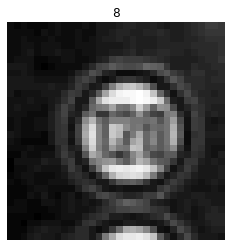

(32, 32)


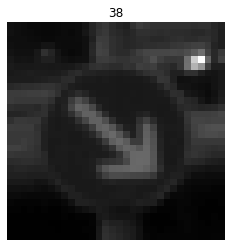

(32, 32)


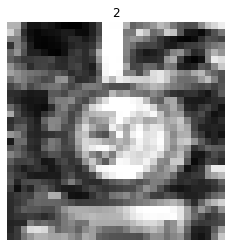

(32, 32)


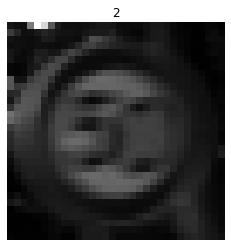

In [12]:
def tensor_image_to_image(tensor_image):
    # From https://stackoverflow.com/questions/64629702/pytorch-transform-totensor-changes-image
    image = np.moveaxis(tensor_image.numpy()*255, 0, -1).astype(np.uint8)

    # From: https://stackoverflow.com/questions/54664329/invalid-dimension-for-image-data-in-plt-imshow
    if image.shape[2] == 1:
        image = np.squeeze(image, axis=-1)

    return image

def show_first_image_in_some_batch(loader, batch_number=42):
    for batch_idx, batch in enumerate(loader):
        ## print("\nBatch = " + str(batch_idx))
        if (batch_idx >= batch_number):
            X = batch[0]
            y = batch[1]
            tensor_image = X[0]
            y_c = y[0]
            image = tensor_image_to_image(tensor_image)
            print(image.shape)
            show_image(image, str(y_c.numpy()))
            break

show_first_image_in_some_batch(train_loader, batch_number=42)
show_first_image_in_some_batch(train_loader, batch_number=42)
show_first_image_in_some_batch(valid_loader, batch_number=42)
show_first_image_in_some_batch(test_loader, batch_number=42)

## 1.4 Build a CNN model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

number_of_classes = number_of_different_traffics_signs
model_cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
                          nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
                          nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
                          Flatten(),
                          nn.Linear(4096, 100), nn.ReLU(),
                          nn.Linear(100, number_of_classes)).to(device)

## 1.5 Explore the model

In [15]:
print(model_cnn.parameters)

def exlorer(loader, model):
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        print(X.shape)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp, y)
        print(loss.item())
        break

exlorer(train_loader, model_cnn)

<bound method Module.parameters of Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
  (8): Flatten()
  (9): Linear(in_features=4096, out_features=100, bias=True)
  (10): ReLU()
  (11): Linear(in_features=100, out_features=43, bias=True)
)>
torch.Size([100, 1, 32, 32])
3.7683675289154053


## 1.6 Train the model

In [16]:
def epoch(loader, model, opt=None):
    total_error = 0.0
    total_loss = 0.0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp, y)
        if opt:
            # In PyTorch, we need to set the gradients to zero before starting to do 
            # backpropragation because PyTorch accumulates the gradients on subsequent 
            # backward passes. 
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_error += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    n = len(loader.dataset)
    epoc_error = total_error / n
    epoc_loss  = total_loss / n

    return epoc_error, epoc_loss

In [17]:
%%time
ts = []
train_errors = []
train_losses = []
valid_errors = []
valid_losses = []

max_epochs = 10
opt = optim.SGD(model_cnn.parameters(), lr=0.1)
for t in range(max_epochs):
    train_error, train_loss = epoch(train_loader, model_cnn, opt)
    valid_error, valid_loss = epoch(valid_loader, model_cnn)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 0.01

    print(f'{t+1}\t{train_error:.6f}\t{train_loss:.6f}\t{valid_error:.6f}\t{valid_loss:.6f}')
    ts.append(t+1)
    train_errors.append(train_error)
    train_losses.append(train_loss)
    valid_errors.append(valid_error)
    valid_losses.append(valid_loss)

print(f'Final Train accuracy      = {100*(1-train_error):.2f}%')
print(f'Final Validation accuracy = {100*(1-valid_error):.2f}%')

1	0.922871	3.437661	0.895238	3.380284
2	0.398632	1.415113	0.180045	0.618391
3	0.075203	0.264099	0.117460	0.422965
4	0.028995	0.108089	0.089342	0.341603
5	0.014397	0.055692	0.105896	0.432134
6	0.003879	0.017111	0.084354	0.379525
7	0.001983	0.010937	0.085941	0.396435
8	0.001437	0.008801	0.086621	0.408143
9	0.001293	0.007390	0.087075	0.428189
10	0.000977	0.006349	0.087528	0.435799
Final Train accuracy      = 99.90%
Final Validation accuracy = 91.25%
CPU times: user 46.9 s, sys: 280 ms, total: 47.2 s
Wall time: 47.1 s


## 1.7 Check overfitting

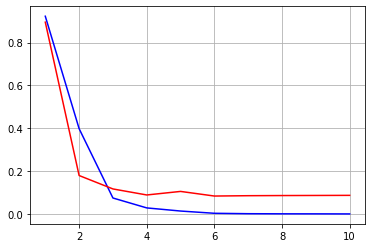

In [18]:
plt.plot(ts, train_errors, '-b')
plt.plot(ts, valid_errors, '-r')
plt.grid()
plt.show()

## 1.8 Calculate the accuracy on the testset

In [19]:
def accuracy(loader, model):
    total_accuracy = 0.0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        yp = model(X)
        total_accuracy += (yp.max(dim=1)[1] == y).sum().item()

    n = len(loader.dataset)
    epoc__accuracy = total_accuracy / n
    return epoc__accuracy

print(f'Train accuracy       = {accuracy(train_loader, model_cnn)*100:.2f}%')
print(f'Validation accuracy  = {accuracy(valid_loader, model_cnn)*100:.2f}%')
print(f'Test accuracy        = {accuracy(test_loader,  model_cnn)*100:.2f}%')

Train accuracy       = 99.94%
Validation accuracy  = 91.25%
Test accuracy        = 90.44%


# 2 Attack!

## 2.-1 Table of ClassId & SignName

```
ClassId,SignName
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)
9,No passing
10,No passing for vechiles over 3.5 metric tons
11,Right-of-way at the next intersection
12,Priority road
13,Yield
14,Stop
15,No vechiles
16,Vechiles over 3.5 metric tons prohibited
17,No entry
18,General caution
19,Dangerous curve to the left
20,Dangerous curve to the right
21,Double curve
22,Bumpy road
23,Slippery road
24,Road narrows on the right
25,Road work
26,Traffic signals
27,Pedestrians
28,Children crossing
29,Bicycles crossing
30,Beware of ice/snow
31,Wild animals crossing
32,End of all speed and passing limits
33,Turn right ahead
34,Turn left ahead
35,Ahead only
36,Go straight or right
37,Go straight or left
38,Keep right
39,Keep left
40,Roundabout mandatory
41,End of no passing
42,End of no passing by vechiles over 3.5 metric tons
```



## 2.0 Init stuff

In [20]:
# See table above
stop_sign_class_id = 14
speed_limit_50_class_id = 2

In [21]:
def get_indices_for_class(ys, classe):
    indexes = []
    for index, y in enumerate(ys):
        if y == classe:
            indexes.append(index)

    return indexes

indexes_stop_sign = get_indices_for_class(y_test, stop_sign_class_id)
X_stop_sign = X_test[indexes_stop_sign]
n = len(indexes_stop_sign)
y_stop_sign = np.ones(n)*stop_sign_class_id

stop_sign_dataset = ImageDataset(X_stop_sign, y_stop_sign, transform=transform)
stop_sign_loader = DataLoader(stop_sign_dataset, batch_size=stop_sign_dataset.__len__(), shuffle=False)

stop_sign_dataset = ImageDataset(X_stop_sign, y_stop_sign, transform=transform)
stop_sign_loader = DataLoader(stop_sign_dataset, batch_size=stop_sign_dataset.__len__(), shuffle=False)

print(X_stop_sign.shape)

(270, 32, 32, 3)


## 2.1 Untargeted attack using Fast Gradient Sign Method (FGSM)

In [22]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [23]:
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
    plt.tight_layout()

In [24]:
# TODO: Interesting hack!
for X,y in stop_sign_loader:
    X,y = X.to(device), y.to(device)
    break

print(X.shape)
print(y.shape)

torch.Size([270, 1, 32, 32])
torch.Size([270])


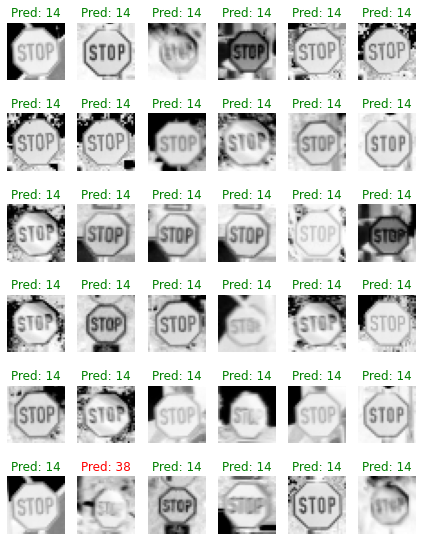

In [25]:
### Illustrate original predictions
yp = model_cnn(X)
plot_images(X, y, yp, 6, 6)

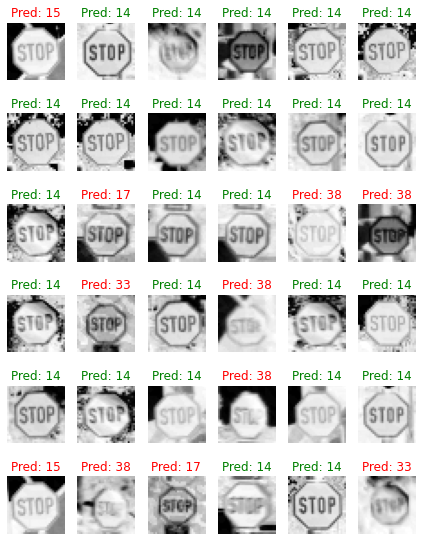

In [26]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.01)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 6, 6)

In [27]:
def epoch_adversarial(model, loader, attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, *args)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [28]:
print("Epoch error :", epoch_adversarial(model_cnn, stop_sign_loader, fgsm, 0.01)[0])

Epoch error : 0.2962962962962963


## 2.2 Untargeted attack using Projected Gradient Descent

In [29]:
# The (normalized) steepest descent
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

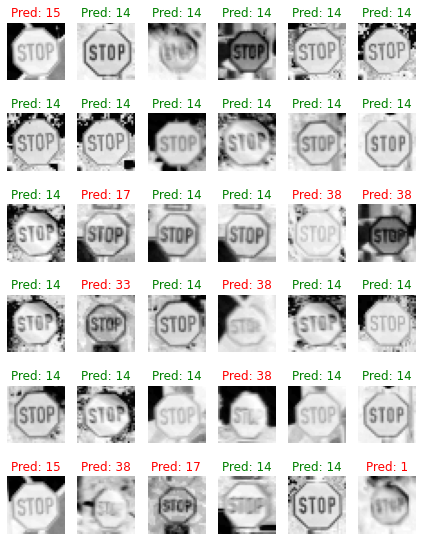

In [30]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.01, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 6, 6)

In [31]:
print("Epoch error :", epoch_adversarial(model_cnn, stop_sign_loader, pgd_linf, 0.01, 1e-2, 40)[0])

Epoch error : 0.3148148148148148


## 2.3 Targeted attack using Projected Gradient Descent ver 1

In [32]:
# Switch to the Speed Limit 50 km/h signs
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

print(X.shape)
print(y.shape)

torch.Size([100, 1, 32, 32])
torch.Size([100])


In [33]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

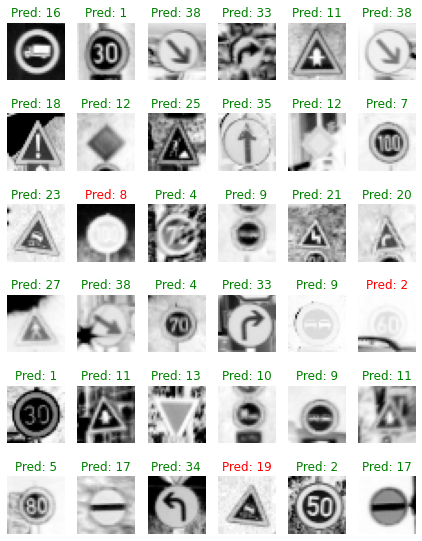

In [34]:
### Illustrate original predictions
yp = model_cnn(X)
plot_images(X, y, yp, 6, 6)

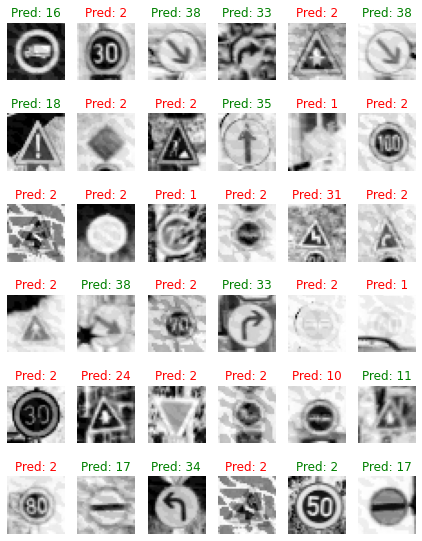

In [35]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.03, alpha=1e-2, num_iter=40, y_targ=speed_limit_50_class_id)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 6, 6)

In [36]:
# An example of a successful attack
i = 12-1
image = tensor_image_to_image(X[i])
show_image(image, 'Original: ' + str(y[i].numpy()))
image = tensor_image_to_image(X[i] + delta[i])
show_image(image, 'Attacked: ' + str(yp[i].max(dim=0)[1].numpy()))

TypeError: ignored

In [ ]:
%%time
epoch_error = epoch_adversarial(
    model_cnn, 
    test_loader, 
    pgd_linf_targ, 0.03, 1e-2, 40, speed_limit_50_class_id)[0]

print("Epoch error :", epoch_error)

In [ ]:
print(f'Accuracy = {100*(1-epoch_error):.2f}%')

## 2.4 Targeted attack using Projected Gradient Descent ver 2

In [ ]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
delta = pgd_linf_targ2(model_cnn, X, y, epsilon=0.03, alpha=1e-2, num_iter=40, y_targ=speed_limit_50_class_id)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 6, 6)

In [ ]:
# Number 11 is not a success anymore, but...
# An example of a successful attack
i = 5*6+1-1
image = tensor_image_to_image(X[i])
show_image(image, 'Original: ' + str(y[i].numpy()))
image = tensor_image_to_image(X[i] + delta[i])
show_image(image, 'Attacked: ' + str(yp[i].max(dim=0)[1].numpy()))

In [ ]:
%%time
epoch_error = epoch_adversarial(
    model_cnn, 
    test_loader, 
    pgd_linf_targ2, 0.03, 1e-2, 40, speed_limit_50_class_id)[0]

print("Epoch error :", epoch_error)

In [ ]:
print(f'Accuracy = {100*(1-epoch_error):.2f}%')

In [ ]:
# The End